In [1]:
import pandas as pd
import spotipy
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np
# Import the os module and necessary OAuth manager
import os 
from spotipy.oauth2 import SpotifyOAuth 

In [2]:
os.environ["SPOTIPY_CLIENT_ID"] = "a5fd8b55abc54dc3a8ef86cb22685dfa"
os.environ["SPOTIPY_CLIENT_SECRET"] = "0f5ce914ad1a40fa91a1584d3aabf9a6"
os.environ["SPOTIPY_REDIRECT_URI"] = 'http://127.0.0.1:8888/callback'


# Define the permissions (scopes) needed for user playlists
scope = "user-library-read playlist-modify-private playlist-modify-public" # <-- Add the scope here

# Initialize Spotipy with the OAuth manager
# The first time you run this, a browser will open for authentication.
try:
    sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope)) 
except Exception as e:
    print(f"Authentication failed. Ensure environment variables are set and the redirect URI is correct in the dashboard. Error: {e}")
    exit() # Stop execution if auth fails

playlist_2024_id = "5TyyS8cT99322V5KcFrJnW"
playlist_2025_id = "6i0LNQ0QCzlFGx2lZXxSdj"

In [3]:
# Verify initial connection (using public data for the print check)
playlist24 = sp.playlist(playlist_2024_id)
playlist25= sp.playlist(playlist_2025_id)
print("Playlist name:", playlist24['name'],"Number of tracks:", playlist24['tracks']['total'])
print("Playlist name:", playlist25['name'],"Number of tracks:", playlist25['tracks']['total'])


Playlist name: Gab's Top Songs 2024 Number of tracks: 100
Playlist name: Gab's Top Songs 2025 Number of tracks: 100


In [4]:
# Function to fetch tracks metadata including Artist ID
def get_playlist_metadata_with_ids(playlist_id, year):
    print(f"--- Starting metadata pull for year {year} ---")
    results = sp.playlist_tracks(playlist_id, fields='items.track.id,items.track.name,items.track.artists(id,name),items.track.popularity,next')
    tracks_items = results['items']
    while results['next']:
        results = sp.next(results)
        tracks_items.extend(results['items'])

    data = []
    for item in tracks_items:
        track = item.get('track')
        if track and track.get('id'):
            data.append({
                'track_name': track['name'],
                'artist': track['artists'][0]['name'] if track['artists'] else 'Unknown',
                'artist_id': track['artists'][0]['id'] if track['artists'] else 'Unknown',
                'popularity': track['popularity'],
                'year': year,
                'track_id': track['id']
            })
    
    df = pd.DataFrame(data)
    print(f"✅ Retrieved {len(df)} tracks and artist IDs for year {year}.")
    return df

# Fetching the data with the new function
df_2024_ids = get_playlist_metadata_with_ids(playlist_2024_id, 2024) 
df_2025_ids = get_playlist_metadata_with_ids(playlist_2025_id, 2025)
df_combined= pd.concat([df_2024_ids, df_2025_ids], ignore_index=True)

--- Starting metadata pull for year 2024 ---
✅ Retrieved 100 tracks and artist IDs for year 2024.
--- Starting metadata pull for year 2025 ---
✅ Retrieved 100 tracks and artist IDs for year 2025.


C:\Users\gabby\AppData\Local\Temp\ipykernel_30636\2283499430.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Playlist Year')


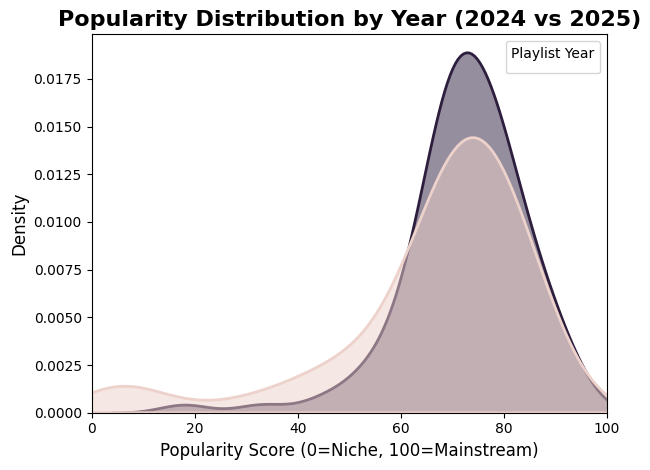

In [5]:
# Distribution of Track Popularity
# Use a KDE plot for a smooth representation of the data distribution
sns.kdeplot(data=df_combined, x='popularity', hue='year', fill=True, alpha=0.5, linewidth=2)

plt.title('Popularity Distribution by Year (2024 vs 2025)', fontsize=16, fontweight='bold')
plt.xlabel('Popularity Score (0=Niche, 100=Mainstream)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xlim(0, 100)
plt.legend(title='Playlist Year')
plt.tight_layout()
plt.show()

C:\Users\gabby\AppData\Local\Temp\ipykernel_30636\121459142.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_artists.values, y=top_artists.index, palette="viridis")


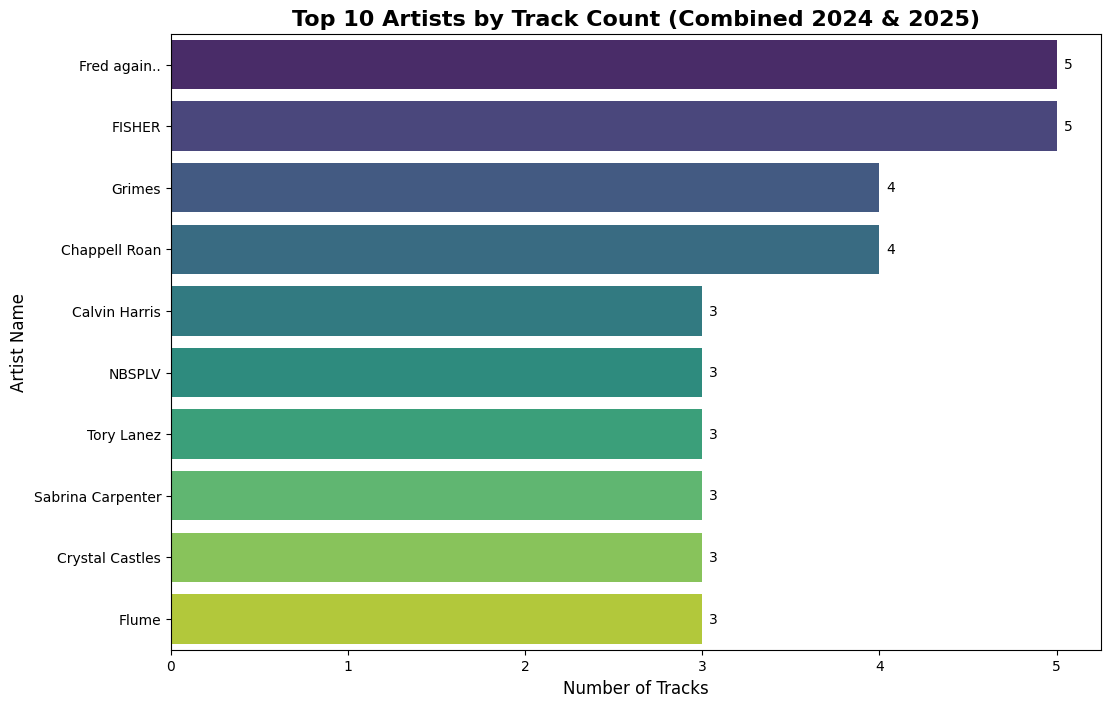

In [6]:
# Top 10 Most Featured Artists
# Calculate the top artists
top_artists = df_combined['artist'].value_counts().head(10)

plt.figure(figsize=(12, 8))

# Use a bar plot with color variance
ax = sns.barplot(x=top_artists.values, y=top_artists.index, palette="viridis")

plt.title('Top 10 Artists by Track Count (Combined 2024 & 2025)', fontsize=16, fontweight='bold')
plt.xlabel('Number of Tracks', fontsize=12)
plt.ylabel('Artist Name', fontsize=12)

# Add counts next to the bars for clarity
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height()/2.),
                ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.show()

C:\Users\gabby\AppData\Local\Temp\ipykernel_30636\2385545407.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df_combined, x='year', y='popularity', palette="coolwarm")


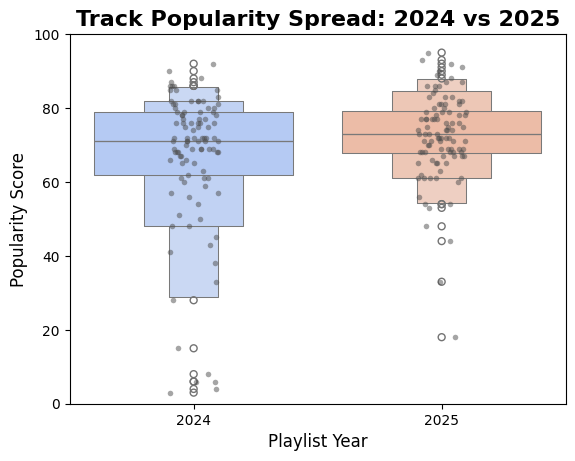

In [7]:
# Popularity Comparison Between Years (Box Plot)
# Boxen plot shows more detail than a standard box plot
sns.boxenplot(data=df_combined, x='year', y='popularity', palette="coolwarm")
sns.stripplot(data=df_combined, x='year', y='popularity', color=".3", size=4, alpha=0.5)

plt.title('Track Popularity Spread: 2024 vs 2025', fontsize=16, fontweight='bold')
plt.xlabel('Playlist Year', fontsize=12)
plt.ylabel('Popularity Score', fontsize=12)
plt.ylim(0, 100)
plt.show()

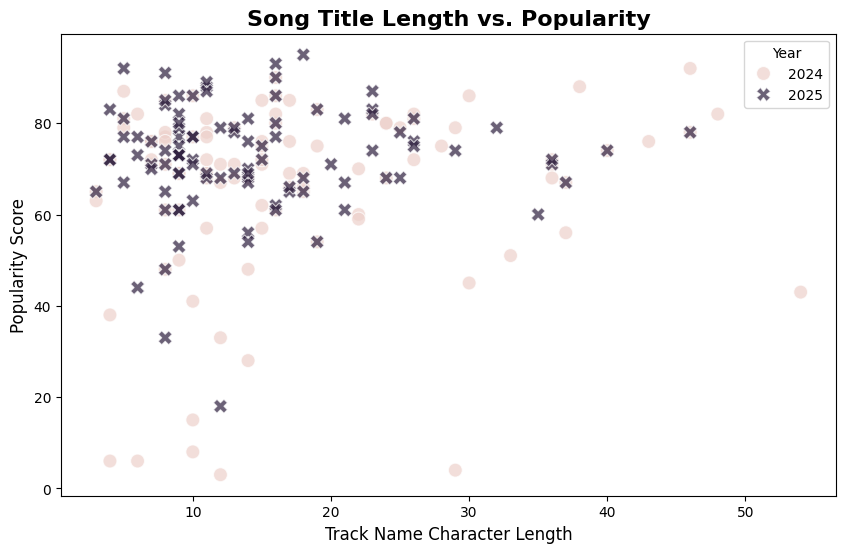

In [8]:
# Bivariate Analysis: Track Name Length vs. Popularity
#  Calculate track name length
df_combined['name_length'] = df_combined['track_name'].apply(len)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_combined, x='name_length', y='popularity', hue='year', style='year', s=100, alpha=0.7)

plt.title('Song Title Length vs. Popularity', fontsize=16, fontweight='bold')
plt.xlabel('Track Name Character Length', fontsize=12)
plt.ylabel('Popularity Score', fontsize=12)
plt.legend(title='Year')
plt.show()

In [9]:
TOP_100 = '5ABHKGoOzxkaa28ttQV9sE' 

# Pull 'Top 100 Played Ever' 
TOP_100_EVER_ID = get_playlist_metadata_with_ids(TOP_100, 'Top 100 Played 2025')

print("\n--- Top 100 Data Loaded ---")
print(TOP_100_EVER_ID.head())
print(TOP_100_EVER_ID.info())

--- Starting metadata pull for year Top 100 Played 2025 ---
✅ Retrieved 100 tracks and artist IDs for year Top 100 Played 2025.

--- Top 100 Data Loaded ---
          track_name             artist               artist_id  popularity  \
0    Blinding Lights         The Weeknd  1Xyo4u8uXC1ZmMpatF05PJ          91   
1       Shape of You         Ed Sheeran  6eUKZXaKkcviH0Ku9w2n3V          89   
2            Starboy         The Weeknd  1Xyo4u8uXC1ZmMpatF05PJ           4   
3    Sweater Weather  The Neighbourhood  77SW9BnxLY8rJ0RciFqkHh          93   
4  Someone You Loved      Lewis Capaldi  4GNC7GD6oZMSxPGyXy4MNB          88   

                  year                track_id  
0  Top 100 Played 2025  0VjIjW4GlUZAMYd2vXMi3b  
1  Top 100 Played 2025  7qiZfU4dY1lWllzX7mPBI3  
2  Top 100 Played 2025  5aAx2yezTd8zXrkmtKl66Z  
3  Top 100 Played 2025  2QjOHCTQ1Jl3zawyYOpxh6  
4  Top 100 Played 2025  7qEHsqek33rTcFNT9PFqLf  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Dat

In [10]:
# Find shared artists
artists_yours = set(df_2025_ids['artist'].unique())
artists_Global = set(TOP_100_EVER_ID['artist'].unique())

shared_artists = artists_yours.intersection(artists_Global)

print(f"\n--- Artists Present in Both Your 2025 Playlist and the All-Time Global Top 100 ({len(shared_artists)} found) ---")

# Print the shared artists and which of their songs are in the Global top list
for artist_name in shared_artists:
    Global_songs = TOP_100_EVER_ID[TOP_100_EVER_ID['artist'] == artist_name]
    print(f"\nArtist: {artist_name}")
    print("  Global Hits:", Global_songs['track_name'].tolist())


--- Artists Present in Both Your 2025 Playlist and the All-Time Global Top 100 (6 found) ---

Artist: Sabrina Carpenter
  Global Hits: ['Espresso']

Artist: Lady Gaga
  Global Hits: ['Die With A Smile', 'Shallow']

Artist: Glass Animals
  Global Hits: ['Heat Waves']

Artist: Billie Eilish
  Global Hits: ['lovely (with Khalid)', 'BIRDS OF A FEATHER', 'bad guy']

Artist: Arctic Monkeys
  Global Hits: ['I Wanna Be Yours', 'Do I Wanna Know?']

Artist: Eminem
  Global Hits: ['Without Me', 'Lose Yourself']


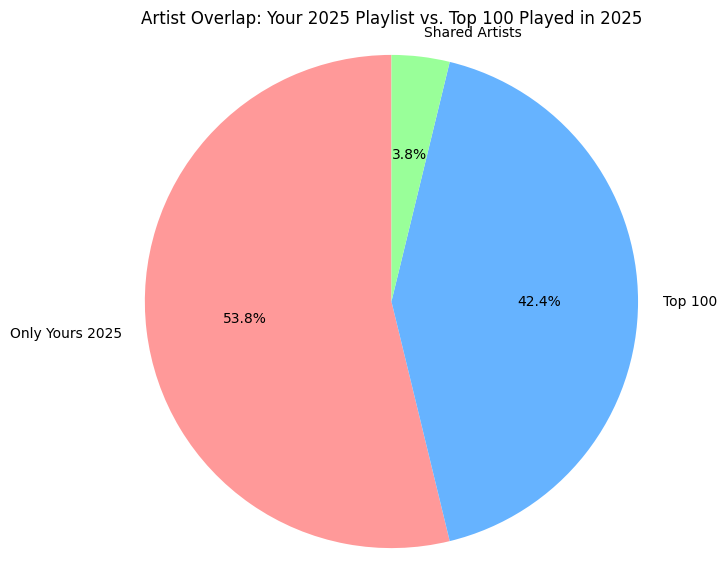

In [11]:
# Counts of unique artists
count_yours = len(artists_yours)
count_Global = len(artists_Global)
count_shared = len(shared_artists)

count_only_yours = count_yours - count_shared
count_only_Global = count_Global - count_shared

labels = ['Only Yours 2025', 'Top 100', 'Shared Artists']
sizes = [count_only_yours, count_only_Global, count_shared]
colors = ['#ff9999','#66b3ff','#99ff99']

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Artist Overlap: Your 2025 Playlist vs. Top 100 Played in 2025')
plt.axis('equal') # Ensure the pie chart is round
plt.show()

In [12]:
# Add a source column to differentiate
df_2025_ids['Source'] = 'Your Playlist 2025'
TOP_100_EVER_ID['Source'] = 'Top 100'

# Concatenate the dataframes for comparison
df_comparison = pd.concat([df_2025_ids, TOP_100_EVER_ID], ignore_index=True)

print("\n--- Combined Comparison DataFrames ---")
print(df_comparison['Source'].value_counts())


--- Combined Comparison DataFrames ---
Source
Your Playlist 2025    100
Top 100               100
Name: count, dtype: int64


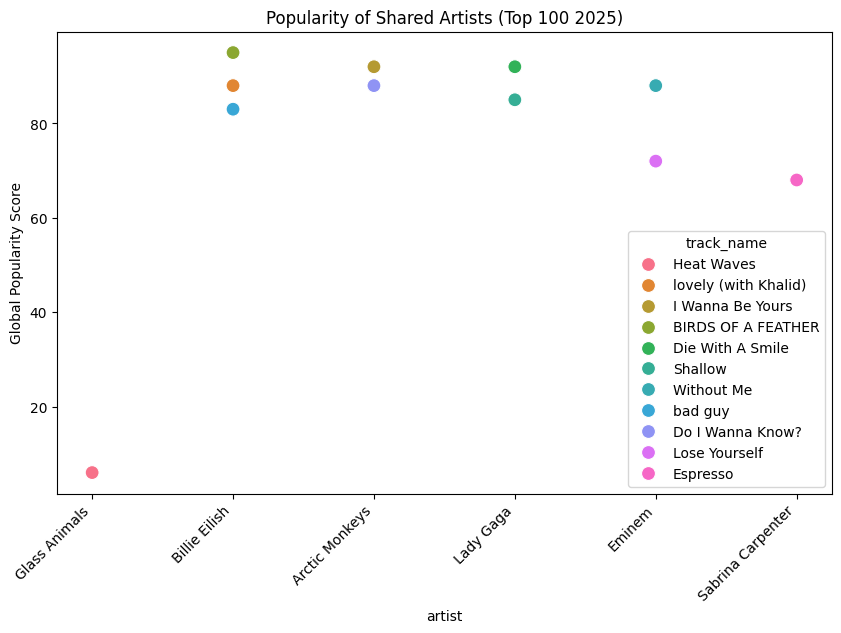

In [13]:
# Assuming 'shared_artists' is the set calculated previously
df_shared = TOP_100_EVER_ID[TOP_100_EVER_ID['artist'].isin(shared_artists)]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_shared, x='artist', y='popularity', hue='track_name', s=100)
plt.title('Popularity of Shared Artists (Top 100 2025)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Global Popularity Score')
plt.show()

C:\Users\gabby\AppData\Local\Temp\ipykernel_30636\2823696618.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_comparison, x='Source', y='popularity', palette="pastel")


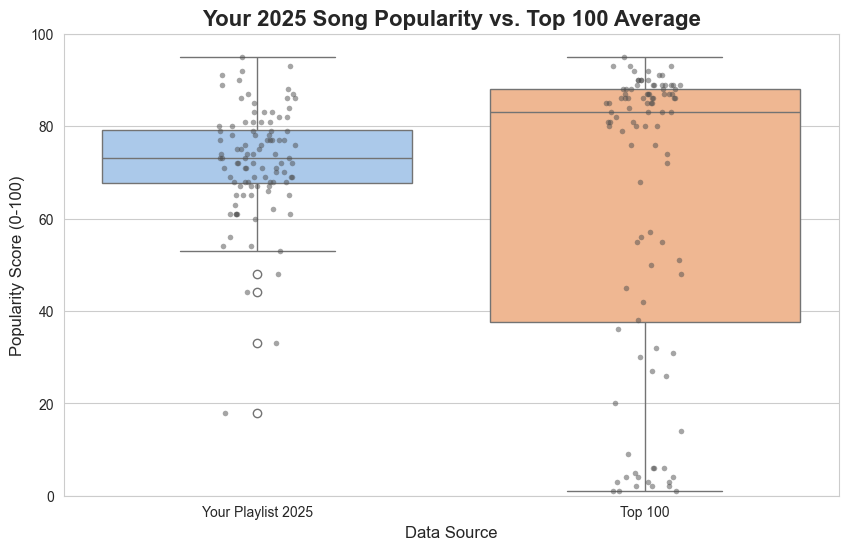

In [14]:
sns.set_style("whitegrid")

# A. Popularity Comparison (Box Plot)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_comparison, x='Source', y='popularity', palette="pastel")
sns.stripplot(data=df_comparison, x='Source', y='popularity', color=".3", size=4, alpha=0.5)

plt.title("Your 2025 Song Popularity vs. Top 100 Average", fontsize=16, fontweight='bold')
plt.xlabel('Data Source', fontsize=12)
plt.ylabel('Popularity Score (0-100)', fontsize=12)
plt.ylim(0, 100)
plt.show()

In [ ]:
# B. Finding Overlap: What songs do you share with the top 100 played?
# Merge the dataframes based on track ID to find common songs
common_songs = pd.merge(df_2025_ids, TOP_100_EVER_ID, on='track_id', suffixes=('_yours', '_Top100'))

if not common_songs.empty:
    print("\n--- Shared Songs Between Your Playlist and Top 100 ---")
    # Display the name, artist, and ranking (popularity score)
    print(common_songs[['track_name_yours', 'artist_yours', 'popularity_Top100']].sort_values(by='popularity_Top100', ascending=False))
else:
    print("\n--- No direct overlap found between your 2025 playlist and the current  Top 100 ---")


--- Shared Songs Between Your Playlist and Top 100 ---
     track_name_yours   artist_yours  popularity_Top100
0  BIRDS OF A FEATHER  Billie Eilish                 95


: 